In [67]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers

In [53]:
print(tf.__version__)
BATCH_SIZE = 32
EPOCHS = 50

2.3.0


In [54]:
data_dir = pathlib.Path('../data/images')
image_count = len(list(data_dir.glob('*/*.jpg')))

In [55]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [56]:
for f in list_ds.take(5):
    print(f.numpy())

b'../data/images/good/c67e243c8_16.jpg'
b'../data/images/bad/2b0d476d6_4.jpg'
b'../data/images/good/39bec5e5e_15.jpg'
b'../data/images/good/d245c4e7f_11.jpg'
b'../data/images/good/2122b99c0_15.jpg'


In [57]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [58]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

14170
3542


In [59]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [256, 256])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img

In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [61]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

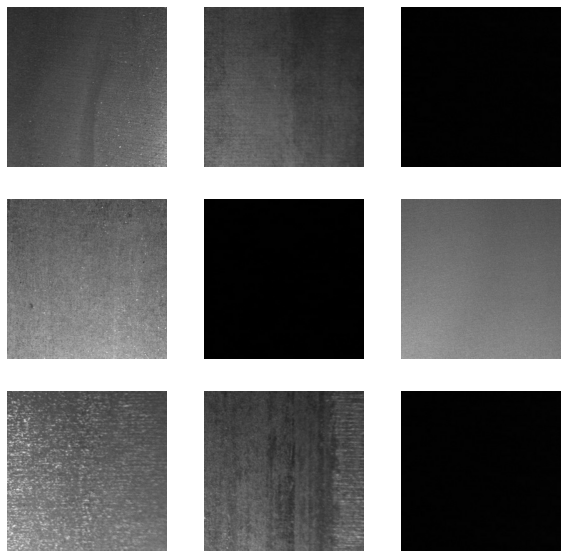

In [62]:
import matplotlib.pyplot as plt
X_batch, _ = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_batch[i].numpy().astype("uint8"))
    plt.axis("off")

In [68]:

class Autoencoder():
    @staticmethod
    def build(width, height, depth, filters=[256,128,64,32], latent_dim=16):
        input_shape = (height, width, depth)
        chan_dim = -1
        
        inputs = layers.Input(shape=input_shape)
        x = inputs
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = layers.Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=chan_dim)(x)
        
        # flatten the network and then construct our latent vector
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        latent = layers.Dense(latent_dim)(x)
        
        encoder = tf.keras.Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(volume_size[1:]))(latent_inputs)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=chan_dim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = layers.Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = layers.Activation("sigmoid")(x)
        
        # build the decoder model
        decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
        
        # our autoencoder is the encoder + decoder
        autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)
        

encoder, decoder, autoencoder = Autoencoder.build(256, 256, 3)


In [69]:
opt = optimizers.Adam(lr=1e-3)
ls = losses.KLDivergence()
autoencoder.compile(optimizer=opt, loss=ls)

In [ ]:
history = autoencoder.fit(train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=val_ds,
                shuffle=True,
                callbacks=[callbacks.TensorBoard(log_dir='../log/autoencoder')])

Epoch 1/50
443/443 [==============================] - 459s 1s/step - loss: 0.1578 - val_loss: 0.0012
Epoch 2/50
 42/443 [=>............................] - ETA: 6:13 - loss: 0.0012

In [ ]:
autoencoder.save('trained')